In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import yt

from spectral_cube import SpectralCube
import astropy.units as u
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits

from pvextractor import Path

%matplotlib notebook

In [2]:
from astropy import wcs
import astropy.units as u

globule = 'GlobC'
source = 'HCOp'

path = globule + '_' + source + '.image.pbcor.fits'

new_cube = fits.open(path)
data = new_cube[0].data
new_header = new_cube[0].header

w = wcs.WCS(new_header)
#print(new_header)

cube = SpectralCube.read(path)
print(cube)
print(cube.spectral_axis)
cube2 = cube.with_spectral_unit(u.GHz)

SpectralCube with shape=(50, 600, 600) and unit=Jy / beam:
 n_x:    600  type_x: RA---SIN  unit_x: deg    range:   337.392579 deg:  337.422840 deg
 n_y:    600  type_y: DEC--SIN  unit_y: deg    range:   -20.813637 deg:  -20.785351 deg
 n_s:     50  type_s: FREQ      unit_s: Hz     range: 89193510279.756 Hz:89200420035.190 Hz
[8.92004200e+10 8.92002790e+10 8.92001380e+10 8.91999970e+10
 8.91998560e+10 8.91997150e+10 8.91995739e+10 8.91994329e+10
 8.91992919e+10 8.91991509e+10 8.91990099e+10 8.91988689e+10
 8.91987279e+10 8.91985868e+10 8.91984458e+10 8.91983048e+10
 8.91981638e+10 8.91980228e+10 8.91978818e+10 8.91977407e+10
 8.91975997e+10 8.91974587e+10 8.91973177e+10 8.91971767e+10
 8.91970357e+10 8.91968946e+10 8.91967536e+10 8.91966126e+10
 8.91964716e+10 8.91963306e+10 8.91961896e+10 8.91960486e+10
 8.91959075e+10 8.91957665e+10 8.91956255e+10 8.91954845e+10
 8.91953435e+10 8.91952025e+10 8.91950614e+10 8.91949204e+10
 8.91947794e+10 8.91946384e+10 8.91944974e+10 8.91943564e+10
 8

KeyError: PhysicalType('frequency')

In [23]:
# Convert velocities into channel numbers
header = cube[0].header
#print(header)
crp1 = header['CRPIX1']
crp2 = header['CRPIX2']
#crp3 = header['CRPIX3']
crv1 = header['CRVAL1']
crv2 = header['CRVAL2']
#crv3 = header['CRVAL3']
cd1 = header['CDELT1']
cd2 = header['CDELT2']
#cd3 = header['CDELT3']

#print(new_header)

freq_start = new_header['CRVAL3'] #header['CRVAL3'] #frequency of initial channel in Hz (Channel 0)
freq_res = new_header['CDELT3'] #header['CDELT3'] #spectral resolution, in Hz
rest_freq = new_header['RESTFRQ'] #header['RESTFRQ'] # Systemic freq in header in Hz
c_vel = 3e5 #speed of light in km/s
vel_start = -c_vel*(1 - freq_start/rest_freq) #velocity of initial channel
vel_change = c_vel*freq_res/rest_freq #Change in velocity per channel
#print('Initial Vel: ','v=%4.1f km/s' %vel_start, ', Vel Change: ', 'v=%4.3f km/s' %vel_change)

In [18]:
# DEFINING USEFUL CONVERSION FUNCTIONS

def hms(hour, mint, sec): # Converts RA hh:mm:ss into degrees
    degree = (hour + (mint + sec/60.)/60.)*360/24
    return degree

def dms(deg, mint, sec): # Converts Dec dd:mm:ss into degrees
    if deg > 0.:
        degree = deg + (mint + sec/60.)/60.
    else:
        degree = -(-deg + (mint + sec/60.)/60.)
    return degree

def Vel_to_Ch(vel_in): # Takes Velocity # and converts to proper channel #
    chan_out = -np.int((vel_in + vel_start) / vel_change)
    return chan_out
def Ch_to_Vel(chan): # Converts Channel number to Velocity
    vel_out = -chan*vel_change - vel_start
    return vel_out

V1 = Vel_to_Ch(-15)
V1 = 50
#Vsys = Vel_to_Ch(-16.6)
V2 = Vel_to_Ch(-19)
V2 = 0
print(V1, V2)

def Pix_to_Angle(PixIn, axis): # Converts image pixel values to RA and Dec angles
    if axis == 'dec':
        Angle = (PixIn - crp2) * cd2 + crv2
    if axis == 'ra':
        Angle = (PixIn - crp1) * cd1 + crv1
    return Angle

def Angle_to_Pix(Angle, axis): # Converts RA or Dec value to image pixel value
    if axis == 'dec':
        PixVal = np.int(crp2 + (Angle - crv2)/cd2)
    if axis == 'ra':
        PixVal = np.int(crp1 + (Angle - crv1)/cd1)
    return PixVal

bmaj = (header["BMAJ"])/(-cd1)
bmin = (header["BMIN"])/cd2
#print(crv2)

50 0


In [19]:
# DEFINING THE BOUNDS OF THE IMAGE IN RA/DEC AND PIXELS

ra_center = hms(22, 29, 43.26) #Degrees (5h35m23s) 83.84757
dec_center = dms(-20, 48, 56.77) #Degrees (-5:12:00)
#ra_img = 83.8542 #5:35:25
#dec_img = -5.197 #-5:11:50

if globule == 'GlobB':
    rabox_min = 337.428 #hms(22, 29, 42.72)	#ra_center+1.5/240.
    rabox_max = 337.43248 #hms(22, 29, 43.80)	#ra_center-0.5/240.
    decbox_min = -20.8175 #dms(-20, 49, 04.80)	#dec_center+1/240.
    decbox_max = -20.81354
elif globule == 'GlobC':
    rabox_min = 337.40565 #hms(22, 29, 42.72)	#ra_center+1.5/240.
    rabox_max = 337.40975 #hms(22, 29, 43.80)	#ra_center-0.5/240.
    decbox_min = -20.802 #dms(-20, 49, 04.80)	#dec_center+1/240.
    decbox_max = -20.796 #dms(-20, 48, 48.74)	#dec_center+3/240.

xbox_min = Angle_to_Pix(rabox_min, 'ra')
xbox_max = Angle_to_Pix(rabox_max, 'ra')
xbox_center = Angle_to_Pix(ra_center, 'ra')
ybox_min = Angle_to_Pix(decbox_min, 'dec')
ybox_max = Angle_to_Pix(decbox_max, 'dec')
ybox_center = Angle_to_Pix(dec_center, 'dec')

bmaj_deg = dms(0, 0, 1.23610949685072)
print(bmaj_deg)

#bmaj = Angle_to_Pix(1.23610949685072, 'ra')
#bmin = Angle_to_Pix(header['BMIN'], 'dec')

#print(bmaj, bmin)

print('Box Dimensions: ', xbox_min, '-', xbox_max, ',', ybox_min, '-', ybox_max, 'in pixels')
print('Box Dimensions: ', rabox_min, '-', rabox_max, ',', decbox_min, '-', decbox_max, 'in degrees')

-0.00034336374912520004
Box Dimensions:  344 - 257 , 247 - 374 in pixels
Box Dimensions:  337.40565 - 337.40975 , -20.802 - -20.796 in degrees


In [22]:
cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention = 'optical')
print(cube_kms.shape)
cube_small = cube_kms[V2:V1,ybox_min:ybox_max,xbox_max:xbox_min] #Channels, Dec range, RA range
# Channel 956 is 11.3 km/s, or about the central velocity
# Channel 820 is 97.6 km/s, or the end of the redshifted jet (other end is 32.5km/s or Chan 922)
print(cube_small.shape)
#print(cube_small.header)

KeyError: PhysicalType('frequency')

In [49]:
WCS(cube_small[0].header)
#WCS(cube_small[0].header, naxis=2)

WCS1 is missing card PV2_1
WCS1 is missing card PV2_2


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 337.407684391  -20.79947071455  
CRPIX : 44.0  54.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -4.722222222222e-05  4.722222222222e-05  
NAXIS : 87  127

In [12]:
moment_0 = cube_small.moment(order=0) #Want to target velocities b/t 0-7.5 & 12.5-30 km/s
mask = np.isnan(moment_0)
masked_mom0 = np.ma.masked_array(moment_0.value, mask = mask)

from astropy.stats import sigma_clip

sigma_mask = sigma_clip(masked_mom0, sigma=3, maxiters=None, cenfunc='mean')
newmask = (masked_mom0 < np.amax(sigma_mask))
#maskednoise = np.ma.masked_array(moment0, mask = newmask)
    
mom0 = np.ma.array(masked_mom0, mask=newmask)

fig = plt.figure()

#ax1 = plt.axes()
#ax1.set_facecolor("black")
ax = fig.add_subplot(111, projection = moment_0.wcs)
#im = ax.imshow(mom0, cmap = "afmhot", vmin=0, vmax=np.amax(mom0), aspect = 'auto')
im = ax.contour(newmask, levels = 0, aspect = 'auto')
#fig.colorbar(im, label = r"Integrated Intensity($Jy/Beam~km~s^{-1}$)")
t = ax.text(350,50, '{:3.1f} - {:3.1f} km s$^{{-1}}$'.format(30, 0),  color='w', size=10, weight="bold") 
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
plt.xticks(fontsize = 20)

#bmaj = header['BMAJ']*10000#major beam width
#print(bmaj)
#bmin = header['BMIN']*10000 #minor beam width
#print(bmin)
bpa = header['BPA']

x_coord = (xbox_max-xbox_min)*0.1
y_coord = (ybox_max-ybox_min)*0.2
#print(x_coord)

#print(bmaj/10000, bmin/10000, bpa)
#from matplotlib.patches import Ellipse
#beam = Ellipse(xy=(x_coord, y_coord), width=bmaj, height=bmin, angle=bpa, color = 'white', zorder = 1)
#ax.add_artist(beam)

#plt.savefig(globule + '_' + source + 'Moment0_June8.png', bbox_inches='tight')

NameError: name 'cube_small' is not defined

<class 'spectral_cube.lower_dimensional_structures.Projection'>


<IPython.core.display.Javascript object>


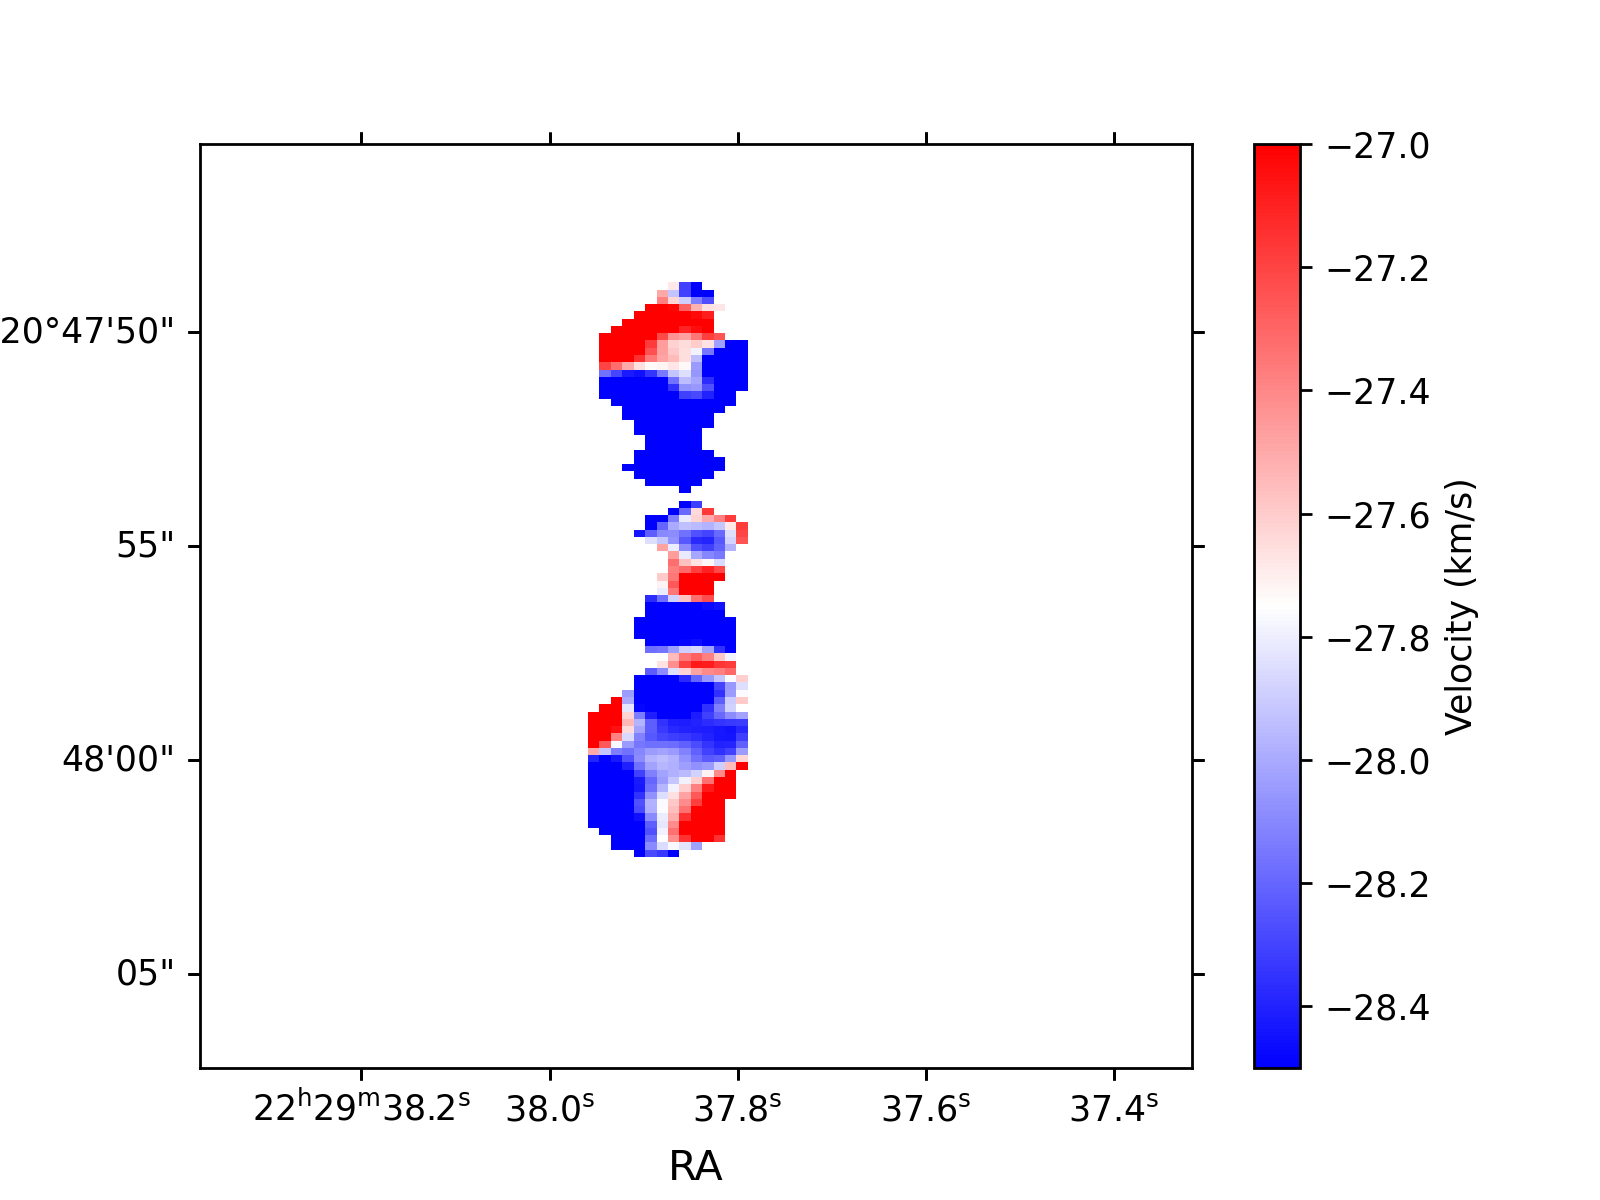

In [21]:
moment_1 = cube_small.moment(order=1).to(u.km/u.s)
masked_vel = np.ma.masked_array(moment_1.value, mask = mask)

from astropy.stats import sigma_clip

sigma_mask = sigma_clip(masked_mom0, sigma=3, maxiters=None, cenfunc='mean')
newmask = (masked_mom0 < np.amax(sigma_mask))
#maskednoise = np.ma.masked_array(moment0, mask = newmask)
    
mom1 = np.ma.array(masked_vel, mask=newmask)
#print(mom1)

print(type(moment_0))

fig = plt.figure()
ax = fig.add_subplot(111, projection = moment_0.wcs)
#im = ax.imshow(mom1, norm = Normalize(vmin = -28.5, vmax = -27), cmap = "bwr", aspect = 'auto')
im = ax.imshow(mom1, norm = Normalize(vmin = -28.5, vmax = -27), cmap = "bwr", aspect = 'auto')
fig.colorbar(im, label = "Velocity (km/s)")

plt.xlabel('RA',fontsize=12)
plt.ylabel('DEC',fontsize=12)

#plt.savefig(globule + '_' + source + 'Moment1_June8.png', bbox_inches='tight')

In [64]:
from pvextractor import Path
from pvextractor import extract_pv_slice
from pvextractor import slice_wcs

width = ybox_max-ybox_center
#print(width)

print(xbox_max, ybox_max)

#new_path = Path([(0, xbox_max/2), (ybox_max-ybox_min, xbox_max/2)], width = ybox_max/2)
#new_slice = extract_pv_slice(cube_small, path = new_path)

#new_path = Path([(0, ybox_max/2), (xbox_max-xbox_min, ybox_max/2)], width = ybox_max/2)
#new_slice = extract_pv_slice(cube_small, path = new_path)

from astropy.coordinates import SkyCoord
if globule == 'GlobB':
    g = SkyCoord([337.428, 337.43248], [-20.81552, -20.81552], frame = 'icrs', unit = 'deg')
    path4 = Path(g, width = 0.00198 * u.deg)
elif globule == 'GlobC':
    g = SkyCoord([337.40565, 337.40975], [-20.799, -20.799], frame = 'icrs', unit = 'deg')
    path4 = Path(g, width = 0.003 * u.deg)
new_slice = extract_pv_slice(cube_small, path = path4)

print(moment_0.wcs)

slice_wcs(moment_0.wcs, spatial_scale = new_header['CDELT2']*u.deg)

#v,npts = pvdiagram(data, endpoints=endpoints)

pv_diagram = new_slice.data
print(pv_diagram.shape)
#tr = scipy.ndimage.rotate(pv_diagram, 0)

#g = ([rabox_min, rabox_max], [decbox_min, decbox_max])
#path4 = Path(g, width=1)

#mask = np.isnan(new_slice)
#masked_slice = np.ma.masked_array(new_slice.value, mask = mask)

fig = plt.figure()
#print(type(new_slice))
#plt.imshow(new_slice.data)
ax = fig.add_subplot(111, projection = pv_diagram.wcs)
im = ax.imshow(pv_diagram, norm = Normalize(vmin = 0, vmax=np.amax(pv_diagram)), cmap = "afmhot", origin = 'lower', aspect = 'auto')
levels = np.linspace(0, np.nanmax(pv_diagram), 8)
ax.contour(pv_diagram, levels = levels[1:10], colors = 'green', origin = 'lower')
fig.colorbar(im, label = "Intensity")

#F2 = aplpy.FITSFigure(new_slice)
#F2.show_grayscale(aspect='auto')

#F2.tick_labels.set_xformat('ddmm')
#F2.tick_labels.set_yformat('kms')

plt.xlabel('Velocity',fontsize=12)
plt.ylabel('DEC',fontsize=12)

#plt.savefig(globule + '_' + source + 'PVDiagram_June8.png', bbox_inches='tight')

152 203

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 337.42934971  -20.81741516796  
CRPIX : 63.0  2.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5e-05  5e-05  
NAXIS : 0  0


IndexError: index 1 is out of bounds for axis 0 with size 1

<IPython.core.display.Javascript object>


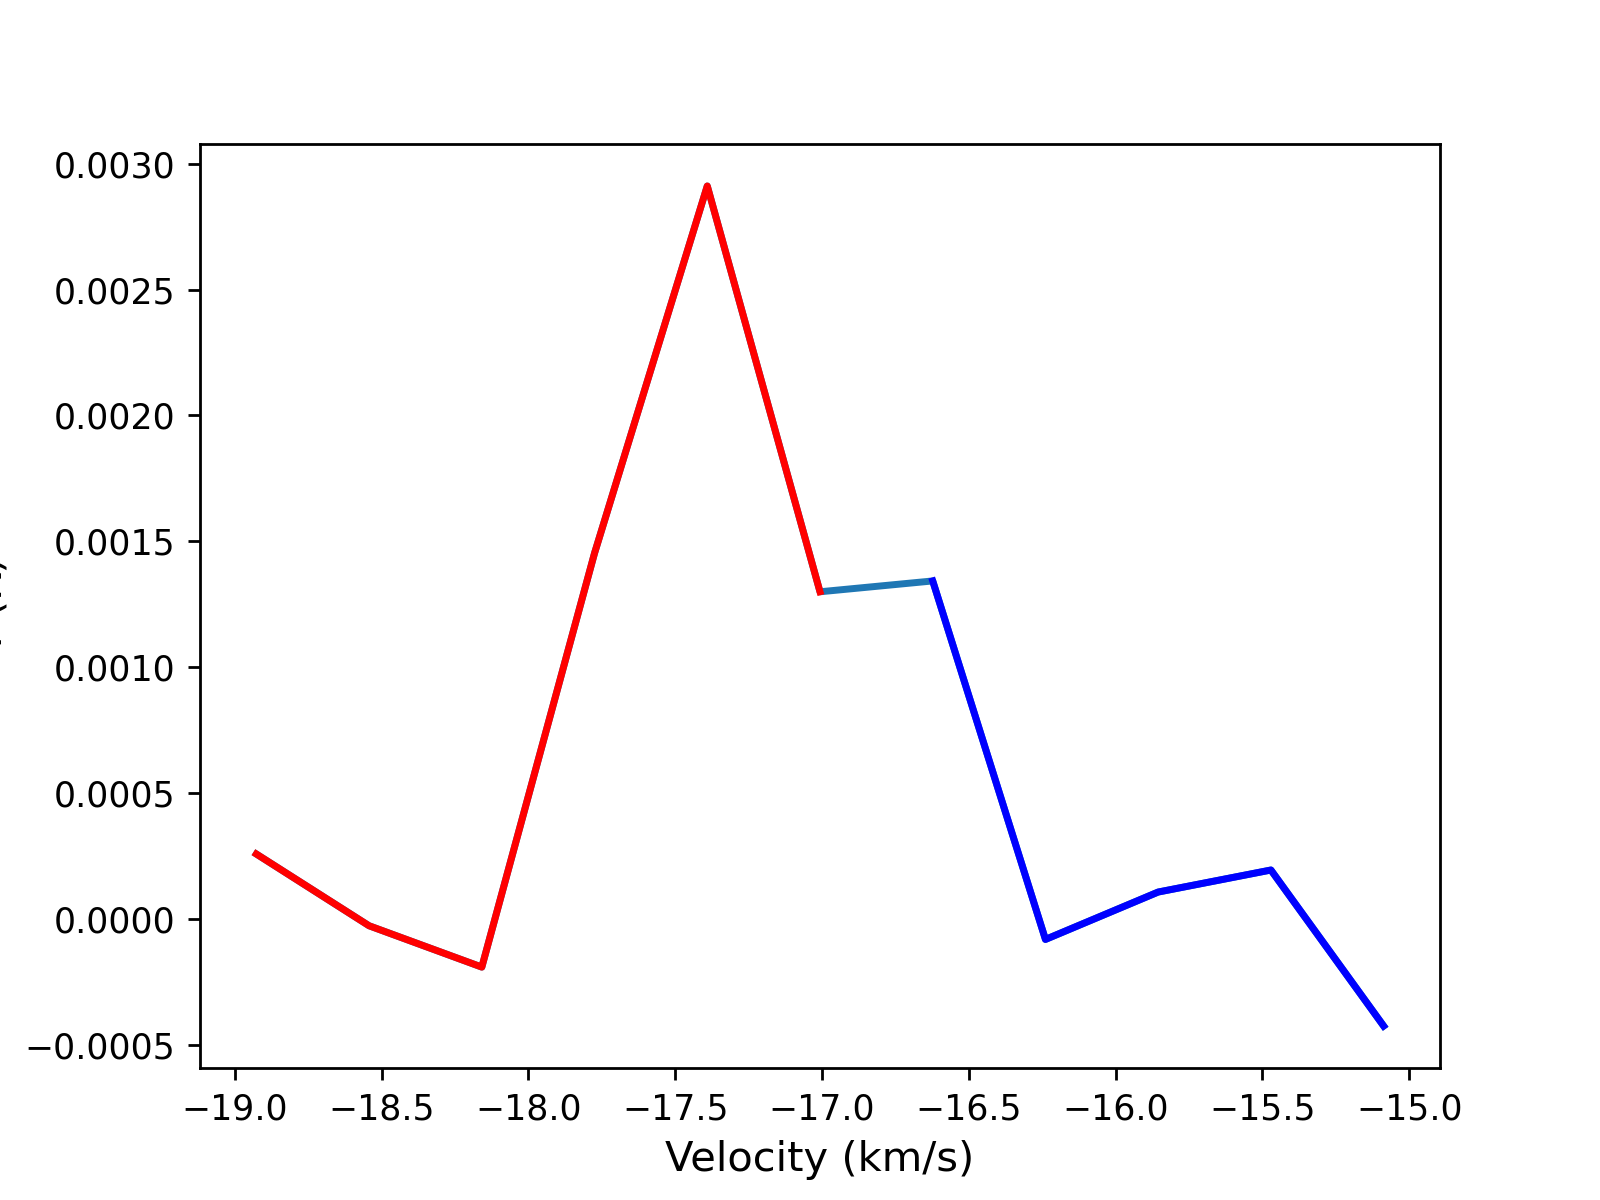

Text(0, 0.5, 'T (K)')

In [262]:
fig, ax = plt.subplots()
spec = np.mean(cube_small, axis = (1,2))
spec_blue = np.mean(cube_kms[Vsys:V1,ybox_min:ybox_max,xbox_min:xbox_max], axis = (1,2))
spec_red = np.mean(cube_kms[V2:Vsys,ybox_min:ybox_max,xbox_min:xbox_max], axis = (1,2))

ax.plot(cube_small.spectral_axis, spec, lw = 2)
ax.plot(cube_kms[Vsys:V1,ybox_min:ybox_max,xbox_min:xbox_max].spectral_axis, spec_blue, lw = 2, color='b')
ax.plot(cube_kms[V2:Vsys,ybox_min:ybox_max,xbox_min:xbox_max].spectral_axis, spec_red, lw = 2, color='r')
ax.set_xlabel("Velocity (km/s)", fontsize = 12)
ax.set_ylabel("T (K)", fontsize = 12)

<IPython.core.display.Javascript object>


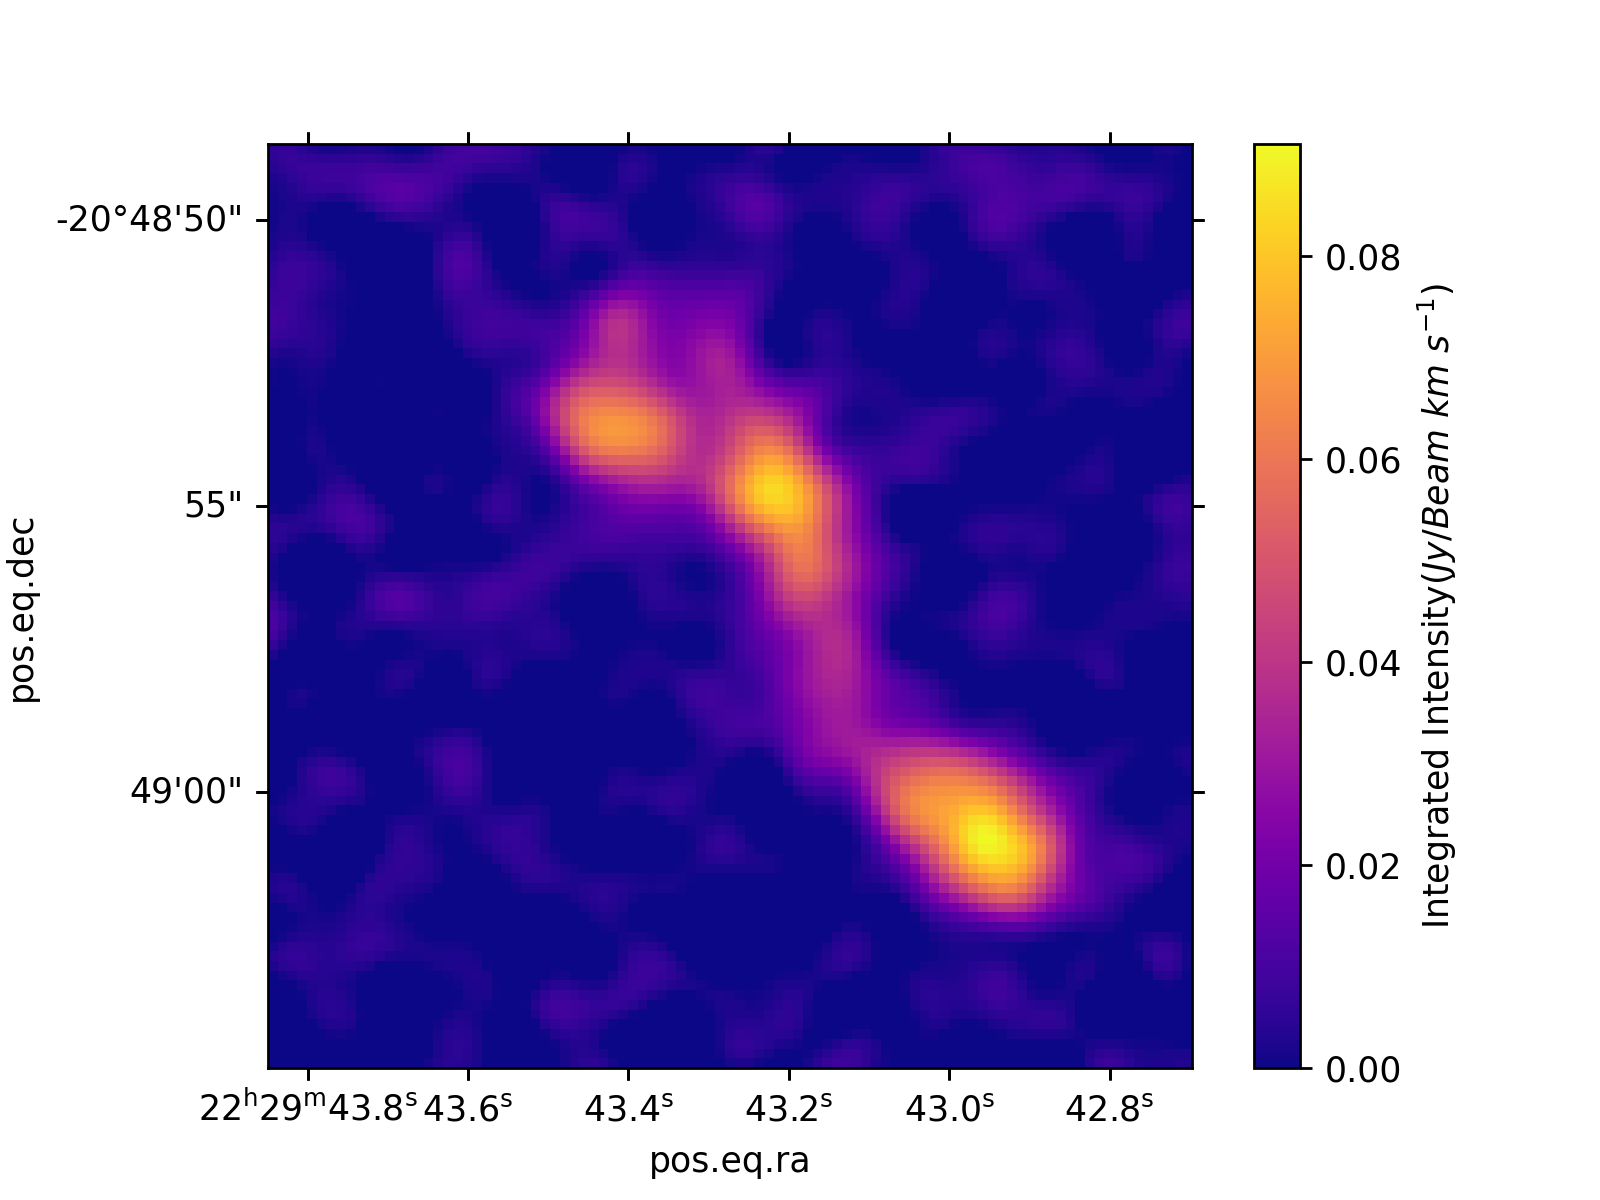

In [67]:
Vel_range = [-22, -10]

jet_m0 = cube_kms[Vel_to_Ch(Vel_range[0]):Vel_to_Ch(Vel_range[1]),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
mask = np.isnan(jet_m0)
masked_mom0 = np.ma.masked_array(jet_m0.value, mask = mask)

fig = plt.figure()
ax = fig.add_subplot(111, projection = moment_0.wcs)
im = ax.imshow(masked_mom0, cmap = "plasma", vmin=0, vmax=np.amax(masked_mom0))
##### Making Color Bar
fig.colorbar(im, label = r"Integrated Intensity($Jy/Beam~km~s^{-1}$)")

t = ax.text(350,50, '{:3.1f} - {:3.1f} km s$^{{-1}}$'.format(Vel_range[0], Vel_range[1]),  color='w', size=10, weight="bold") 

<IPython.core.display.Javascript object>


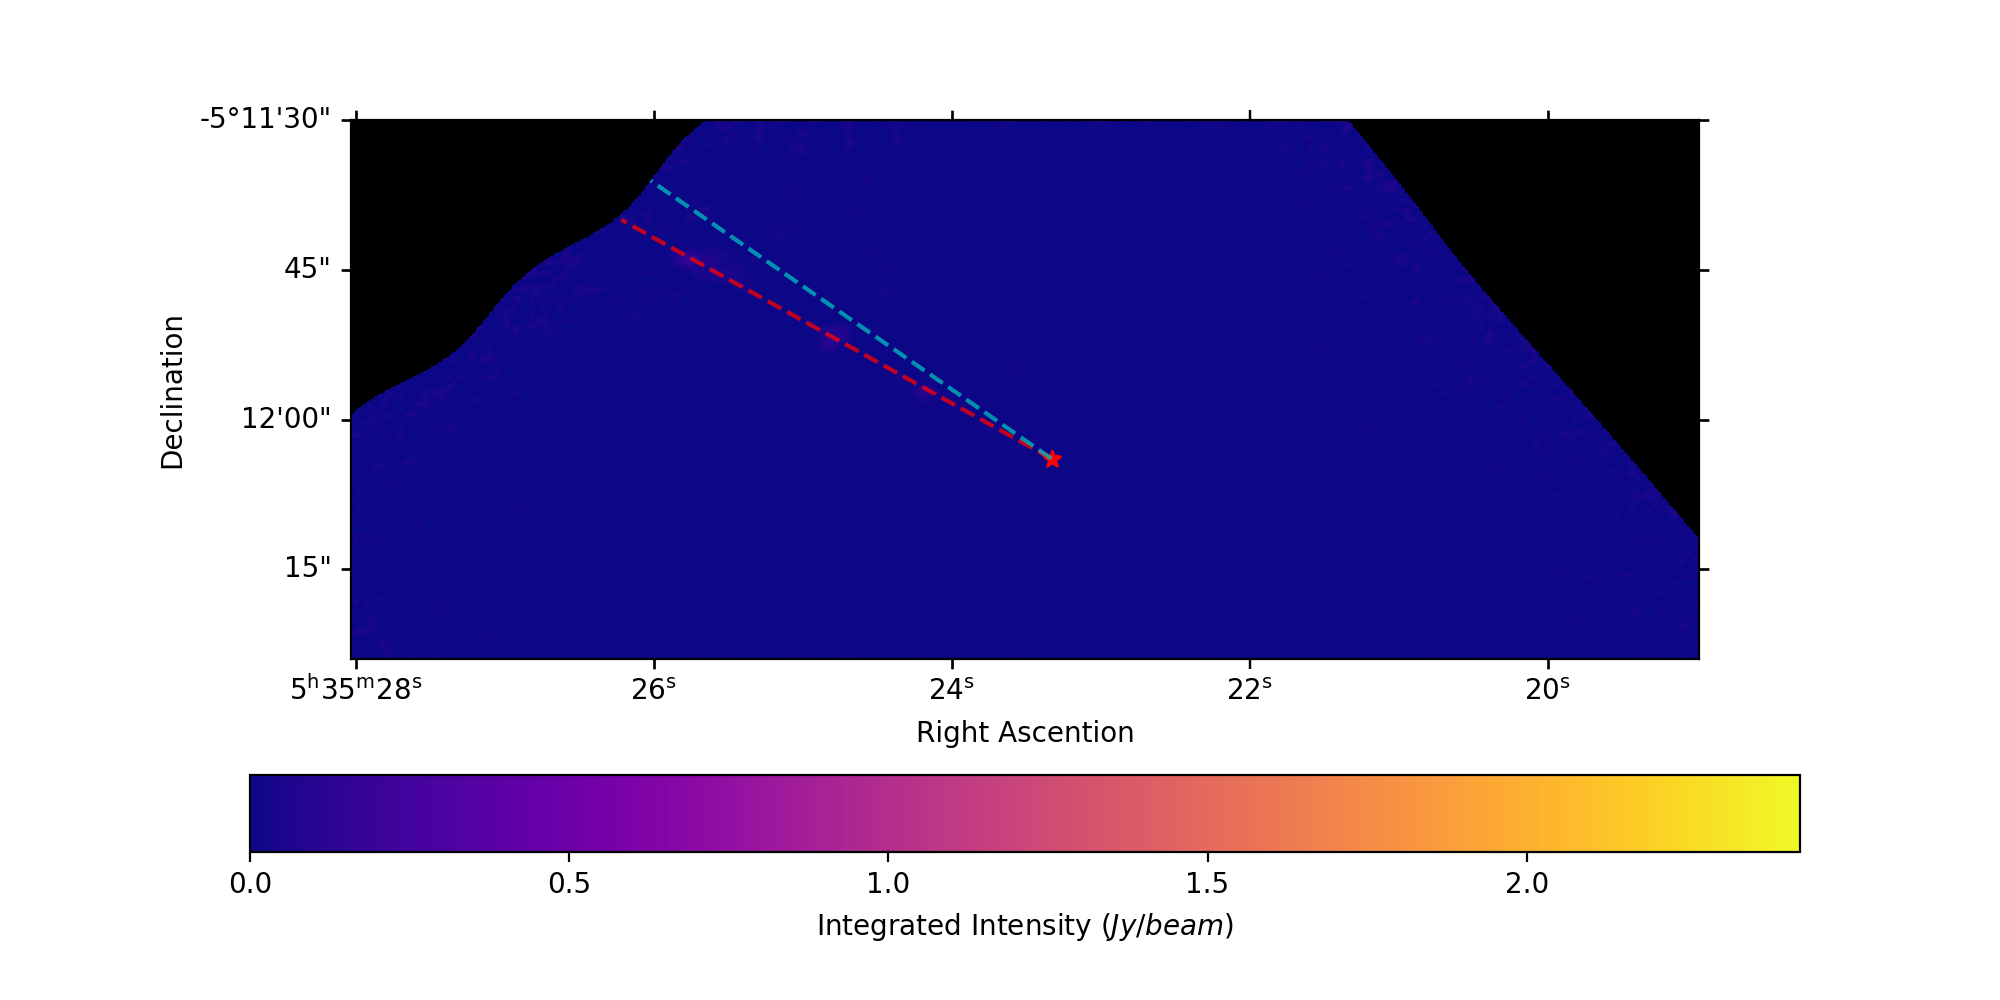

Center pixel of image 482.5 193.0
Center RA/Dec of image 83.84791666666666 -5.199166666666667
Pixel of Star 718 936


In [11]:
# Figure of ~single channel with lines marking projection of jets
jet = 'red'

## CHANNEL RANGES ##
#Channels = [Vel_to_Ch(47),Vel_to_Ch(47)+1] #Blueshifted Jet
#Channels = [Vel_to_Ch(88),Vel_to_Ch(88)+1] #Redshifted Jet
#Channels = [Vel_to_Ch(95),Vel_to_Ch(30)]   #Full Jet Range
#vmax = np.amax(masked_mom0)
#vmax = 0.05
#Title = "OMC2_RedJet_88kms"#"OMC2_BlueJet_47kms"

if jet == 'moment':
    Channels = [Vel_to_Ch(95),Vel_to_Ch(30)]   #Full Jet Range
    Title = "OMC2_Mom0Jets"
    vmax = 2.5
elif jet == 'red':
    Channels = [Vel_to_Ch(88),Vel_to_Ch(88)+1] #Redshifted Jet
    Title = "OMC2_RedJet_88kms"
    vmax = np.amax(masked_mom0)
elif jet == 'blue':
    Channels = [Vel_to_Ch(47),Vel_to_Ch(47)+1] #Redshifted Jet
    Title = "OMC2_BlueJet_47kms"
    vmax = 0.05

#----- NO CHANGES NEEDED BEYOND THIS POINT -----#
jet_m0 = cube_kms[Channels[0]:Channels[1],ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
mask = np.isnan(jet_m0)
masked_mom0 = np.ma.masked_array(jet_m0.value, mask = mask)

def hmspix(hour, mint, sec): # Converts RA hh:mm:ss into pixel of given image
    degree = (hour + (mint + sec/60.)/60.)*360/24
    xpix = np.int(np.shape(masked_mom0)[1]/2 + (hms(hour, mint, sec) - im_cent[0])/cd1)
    return xpix

def dmspix(deg, mint, sec): # Converts Dec dd:mm:ss into degrees
    if deg > 0.:
        degree = deg + (mint + sec/60.)/60.
    else:
        degree = -(-deg + (mint + sec/60.)/60.)
    ypix = np.int(np.shape(masked_mom0)[0]/2 + (dms(deg, mint, sec) - im_cent[1])/cd2)
    return ypix

## MAKING THE FIGURE ##
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection = moment_0.wcs)
cmap = plt.cm.plasma
cmap.set_bad('black',1.)
im = ax.imshow(masked_mom0, cmap = cmap, vmin=0, vmax=vmax)

im_cent = [rabox_min+(rabox_max-rabox_min)/2,decbox_min+(decbox_max-decbox_min)/2]
xstar = hmspix(5,35,23.32) #np.int(np.shape(masked_mom0)[1]/2 + (hms(5,35,23.32) - im_cent[0])/cd1)
ystar = dmspix(-5,12,3.97) #np.int(np.shape(masked_mom0)[0]/2 + (dms(-5,12,3.97) - im_cent[1])/cd2)
ax.plot([hmspix(5,35,23.32),hmspix(5,35,26.2)],[dmspix(-5,12,3.97),dmspix(-5,11,40)],'--r', alpha=0.75) #[x1,x2],[y1,y2]
ax.plot([hmspix(5,35,23.32),hmspix(5,35,26)],[dmspix(-5,12,3.97),dmspix(-5,11,36)],'--c', alpha=0.75) #[x1,x2],[y1,y2]
ax.scatter(xstar,ystar, color='r', marker='*')

plt.xlabel('Right Ascention')
plt.ylabel('Declination')
##### Making Contour Bar
#ax = plt.gca()
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("bottom", size="8%", pad=0.5)
#cb = plt.colorbar(im, label = r"Integrated Intensity ($Jy/beam~km~s^{-1}$)", orientation="horizontal")
cb = plt.colorbar(im, label = r"Integrated Intensity ($Jy/beam$)", orientation="horizontal")
#cb.set_label(cbtitle,size=20)
#cb.ax.tick_params(labelsize=15)
#cax.xaxis.set_ticks_position("top")

print('Center pixel of image',np.shape(masked_mom0)[1]/2,np.shape(masked_mom0)[0]/2)
print('Center RA/Dec of image',rabox_min+(rabox_max-rabox_min)/2,decbox_min+(decbox_max-decbox_min)/2)
print('Pixel of Star', Angle_to_Pix(hms(5,35,22), 'ra'),Angle_to_Pix(dms(-5,12,30), 'dec'))

plt.savefig("/Users/jbublitz/Desktop/OMC2_ALMA_Sokar/Figures/"+Title+".png", dpi=200, bbox_inches="tight", overwrite=True)


In [ ]:
fig = plt.figure(figsize=(10,10))
cmap = plt.cm.inferno
cmap.set_bad('black',1.)


ax3 = plt.subplot(313, projection = moment_0.wcs)   #bottom middle
jet_mom0 = cube_kms[Vel_to_Ch(95):(Vel_to_Ch(30)),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
im3 = ax3.imshow(np.ma.masked_array(jet_mom0.value, mask = np.isnan(jet_mom0)), origin="lower", cmap = cmap, vmin=0)
cb = plt.colorbar(im3, label = r"Integrated Intensity ($Jy/beam$)")
ax3.scatter(xstar,ystar, color='r', marker='*')
t = ax3.text(600,50, '30 - 95 km s$^{{-1}}$',  color='w', size=10, weight="bold") 
plt.xlabel('Right Ascention', fontsize=15)
plt.ylabel('Declination', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = plt.subplot(312, projection = moment_0.wcs, sharex=ax3)   #top right
jet_red = cube_kms[Vel_to_Ch(95):(Vel_to_Ch(75)),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
im2 = ax2.imshow(np.ma.masked_array(jet_red.value, mask = np.isnan(jet_red)), origin="lower", cmap = cmap, vmin=0)#0.2
ax2.plot([hmspix(5,35,23.32),hmspix(5,35,26.2)],[dmspix(-5,12,3.97),dmspix(-5,11,40)],'--r', alpha=0.75) #[x1,x2],[y1,y2]
ax2.plot([hmspix(5,35,23.32),hmspix(5,35,26)],[dmspix(-5,12,3.97),dmspix(-5,11,36)],'--c', alpha=0.75) #[x1,x2],[y1,y2]
ax2.scatter(xstar,ystar, color='r', marker='*')
t = ax2.text(600,50, '75 - 95 km s$^{{-1}}$',  color='w', size=10, weight="bold") 
cb = plt.colorbar(im2)
ax2.tick_params(axis='x', labelbottom=False, labelsize=25)
plt.ylabel(' ')


ax1 = plt.subplot(311, projection = moment_0.wcs, sharex=ax3)   #top left
jet_blue = cube_kms[Vel_to_Ch(60):(Vel_to_Ch(30)),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
im1 = ax1.imshow(np.ma.masked_array(jet_blue.value, mask = np.isnan(jet_blue)), origin="lower", cmap = cmap, vmin=0) #0.05
ax1.plot([hmspix(5,35,23.32),hmspix(5,35,26.2)],[dmspix(-5,12,3.97),dmspix(-5,11,40)],'--r', alpha=0.5) #[x1,x2],[y1,y2]
ax1.plot([hmspix(5,35,23.32),hmspix(5,35,26)],[dmspix(-5,12,3.97),dmspix(-5,11,36)],'--c', alpha=0.5) #[x1,x2],[y1,y2]
ax1.scatter(xstar,ystar, color='r', marker='*')
t = ax1.text(600,50, '30 - 60 km s$^{{-1}}$',  color='w', size=10, weight="bold") 
cb = plt.colorbar(im1)
ax1.tick_params(axis='x', labelbottom=False, labelsize=25)
plt.ylabel(' ')

#plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.1)
#plt.subplot_tool()  # Creates a GUI set of sliders to change spacing
plt.savefig("/Users/jbublitz/Desktop/OMC2_ALMA_Sokar/Figures/OMC2_Jet_trio.pdf", dpi=200, bbox_inches="tight", overwrite=True)
